## A swath snapshot and AICCA labels on the swath
Create a figure like Figure 7 of ```A. Muhlbauer et al.: Climatology of stratocumulus cloud morphologies```

In [1]:
import os
import gc
import sys
import glob
import netCDF4
import numpy as np
import pandas as pd
from pyhdf.SD import SD, SDE
import cartopy as cart
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
from collections import defaultdict

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image
from mpl_toolkits.basemap import Basemap
from pylab import *

In [4]:
# if your python venv does not have lib4modis
try:
    from lib4modis.loader import read_hdf, proc_sds
except:
    from pathlib  import Path
    homedir=str(Path.home())
    clouds_dir="/modis-climate/apps/lib4modis"
    sys.path.insert(1,os.path.join(sys.path[0],homedir+clouds_dir))
    from loader import read_hdf, proc_sds

### Import MOD02/MOD03 data

In [4]:
#hdf_mod02_datadir="/home/tkurihana/scratch-midway2/data/MOD02/MOD021KM/2003/015"
hdf_mod02_datadir="/home/tkurihana/scratch-midway2/data/MOD02/MOD021KM/2003/195"

In [5]:
#hdf_mod03_datadir="/home/tkurihana/scratch-midway2/data/MOD03/MOD03/2003/015"
hdf_mod03_datadir="/home/tkurihana/scratch-midway2/data/MOD03/MOD03/2003/195"

In [6]:
def get_true_color(file_name:str):
    # References:
    # https://earthdata.nasa.gov/sites/default/files/field/document/MODIS_True_Color.pdf
    # http://www.idlcoyote.com/ip_tips/brightmodis.html

    #----------------------------------------------------------------------------------------#
    # inputs
    #file_name = 'MYD021KM.A2013189.1350.006.2013190155358.hdf'
    file = SD(file_name, SDC.READ)
    #----------------------------------------------------------------------------------------#

    selected_sds = file.select('EV_250_Aggr1km_RefSB')
    selected_sds_attributes = selected_sds.attributes()

    for key, value in selected_sds_attributes.items():
    #print key, value
        if key == 'reflectance_scales':
            reflectance_scales_250_Aggr1km_RefSB = np.asarray(value)
        if key == 'reflectance_offsets':
            reflectance_offsets_250_Aggr1km_RefSB = np.asarray(value)

    sds_data_250_Aggr1km_RefSB = selected_sds.get()
    #print 'sds_data shape', sds_data_250_Aggr1km_RefSB.shape
    #print reflectance_scales_250_Aggr1km_RefSB.shape

    #----------------------------------------------------------------------------------------#
    selected_sds = file.select('EV_500_Aggr1km_RefSB')
    selected_sds_attributes = selected_sds.attributes()

    for key, value in selected_sds_attributes.items():
        if key == 'reflectance_scales':
            reflectance_scales_500_Aggr1km_RefSB = np.asarray(value)
        if key == 'reflectance_offsets':
            reflectance_offsets_500_Aggr1km_RefSB = np.asarray(value)

    sds_data_500_Aggr1km_RefSB = selected_sds.get()
    #print reflectance_scales_500_Aggr1km_RefSB.shape
    #----------------------------------------------------------------------------------------#

    data_shape = sds_data_250_Aggr1km_RefSB.shape
    along_track = data_shape[1]
    cross_trak = data_shape[2]

    z = np.zeros((along_track, cross_trak,3))

    for i in np.arange(along_track):
        for j in np.arange(cross_trak): 
            z[i,j,0] = ( sds_data_250_Aggr1km_RefSB[0,i,j] - \
            reflectance_offsets_250_Aggr1km_RefSB[0] ) * \
            reflectance_scales_250_Aggr1km_RefSB[0] 

    for i in np.arange(along_track):
        for j in np.arange(cross_trak): 
            z[i,j,1] = ( sds_data_500_Aggr1km_RefSB[1,i,j] - \
            reflectance_offsets_500_Aggr1km_RefSB[1] ) * \
            reflectance_scales_500_Aggr1km_RefSB[1]  

    for i in np.arange(along_track):
        for j in np.arange(cross_trak): 
            z[i,j,2] = ( sds_data_500_Aggr1km_RefSB[0,i,j] - \
            reflectance_offsets_500_Aggr1km_RefSB[0] ) * \
            reflectance_scales_500_Aggr1km_RefSB[0] 

    z[ z > 1 ] = 1.0
    z[ z < 0 ] = 0.0
    
    #----------------------------------------------------------------------------------------#
    # Color enhancement

    x = np.array([0,  30,  60, 120, 190, 255], dtype=np.uint8)
    y = np.array([0, 110, 160, 210, 240, 255], dtype=np.uint8)

    def scale_image(image, x, y):
        scaled = np.zeros((along_track, cross_trak), dtype=np.uint8)
        for i in range(len(x)-1):
            x1 = x[i]
            x2 = x[i+1]
            y1 = y[i]
            y2 = y[i+1]
            m = (y2 - y1) / float(x2 - x1)
            b = y2 - (m *x2)
            mask = ((image >= x1) & (image < x2))
            scaled = scaled + mask * np.asarray(m * image + b, dtype=np.uint8)

        mask = image >= x2
        scaled = scaled + (mask * 255)

        return scaled

    def bytescale(swath):
        swath = np.nan_to_num(swath.astype(np.float64),  nan=255)
        swath = swath/np.max(swath)*255
        swath = swath.astype(np.uint8)
        return swath
    
    z_color_enh = np.zeros((along_track, cross_trak,3), dtype=np.uint8)
    z_color_enh[:,:,0] = scale_image(bytescale(z[:,:,0]), x, y)
    z_color_enh[:,:,1] = scale_image(bytescale(z[:,:,1]), x, y)
    z_color_enh[:,:,2] = scale_image(bytescale(z[:,:,2]), x, y)
    return z_color_enh

In [17]:
# MOD02
def gen_sds(ifile, ref_var1='EV_250_Aggr1km_RefSB', ref_var2='EV_500_Aggr1km_RefSB',  ref_bands=[],  ):

        ref_sds1 = read_hdf(ifile, varname=ref_var1) # 1 - 2
        ref_sds2 = read_hdf(ifile, varname=ref_var2) # 3 - 7 
        # Abort stopper for HDF-open error    
        if ref_sds1 is None or ref_sds2 is None:
            raise ValueError("ref_sds is None: Check file")  

        ref_array1, cref_bands1 = proc_sds(ref_sds1)
        ref_array2, cref_bands2 = proc_sds(ref_sds2)
        print(cref_bands1, cref_bands2)
        # data concatenation
        #swath = aug_array(ref_array, np.zeros(ref_array.shape),
        #          ref_bands=ref_bands, ems_band=[],
        #          cref_bands=cref_bands, cems_bands=[])
        ref_array = np.concatenate([ref_array1, ref_array2], axis=0)
        swath = np.concatenate( [ np.expand_dims(ref_array[i], axis=-1) for i in ref_bands ], axis=-1 )
        return ifile, swath

In [18]:
def proc_coord(sds_array):
            """ sds_array = hdf_m03.select("Longitude")
            """
            array = sds_array.get()
            array = array.astype(np.float32)
            nan_idx = np.where( array == sds_array.attributes()['_FillValue'])
            if len(nan_idx) > 0:
              array[nan_idx] = np.nan
            return array

In [9]:
mod021km_hdf = glob.glob(os.path.join(hdf_mod02_datadir, "*.hdf"))[0]

In [19]:
#mod03_hdf = glob.glob(os.path.join(hdf_mod03_datadir, "*.hdf"))[0]
mod03_hdf = glob.glob(os.path.join(hdf_mod03_datadir, "MOD03.A2003195.1620.061.2017193153042.hdf"))[0]

In [20]:
hdf_m03 = SD(mod03_hdf, SDC.READ)
lats = proc_coord(hdf_m03.select("Latitude") )
lons = proc_coord(hdf_m03.select("Longitude") )

In [12]:
mod021km_hdf , mod03_hdf

('/home/tkurihana/scratch-midway2/data/MOD02/MOD021KM/2003/195/MOD021KM.A2003195.1620.061.2017194170710.hdf',
 '/home/tkurihana/scratch-midway2/data/MOD03/MOD03/2003/195/MOD03.A2003195.1620.061.2017193153042.hdf')

In [13]:
#_, swath = gen_sds(mod021km_hdf, ref_bands=[0,3,2])#
swath = get_true_color(mod021km_hdf)

In [9]:
swath.shape

(2030, 1354, 3)

In [21]:
# save as np.file
#np.save("TrueColor-MOD021KM.A2003015.1650.061.2017187165553.png", swath)
#np.save("TrueColor-MOD021KM.A2003015.1825.061.2017187170219.png", swath)
#np.save("TrueColor-MOD021KM.A2003195.1620.061.2017194170710.png", swath)

#### Load saved data

In [22]:
#swath = np.load("TrueColor-MOD021KM.A2003015.1650.061.2017187165553.png.npy")
swath = np.load("TrueColor-MOD021KM.A2003195.1620.061.2017194170710.png.npy")

### Visualize single channel

In [8]:
# Get customized color scheme
# https://stackoverflow.com/questions/64633018/removing-white-or-light-colors-from-matplotlib-color-palette
min_val, max_val = 0.3,1
n = 10
orig_cmap = plt.cm.ocean
colors = orig_cmap(np.linspace(min_val, max_val, n))
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)

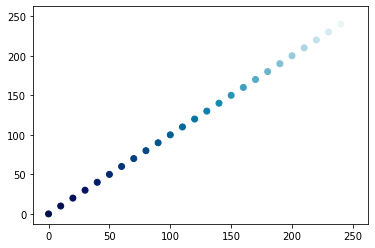

In [6]:
plt.scatter(np.arange(0,255,10), np.arange(0,255,10), c=np.arange(0,255,10), cmap=mycmap)

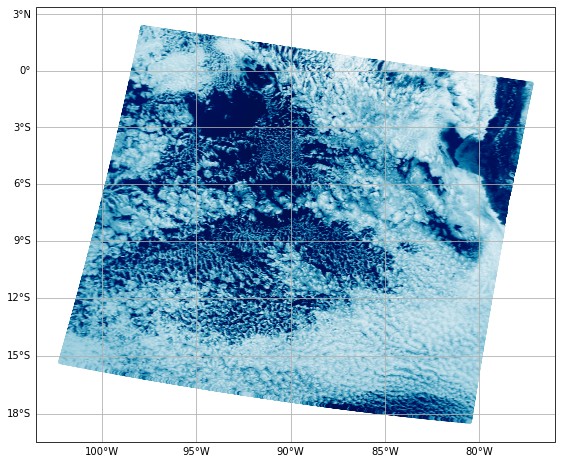

In [29]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Miller())
ax.scatter(lons, lats, c=swath[:,:,0], s=5, cmap=mycmap)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

### Load labels

In [9]:
label_basedir="/home/tkurihana/scratch-midway2/data/MODIS-NC-20years"
label_datadir=f"{label_basedir}/2003-015-105-195-288_053-132-185-315/2003/195/nc2-npb128-cpw1.0-ib1-mb1-mb1"

In [10]:
filename=os.path.join(label_datadir, "CMPSTMOD021KM.A2003195.1620.061.2017194170710.nc")

In [11]:
def read_netcdf(f, varname):
    nc = netCDF4.Dataset(f, 'r')
    var = nc.variables[varname][:]
    #print([ i for i in nc.variables])
    nc.close()
    return var

In [12]:
nclusters=10 #256 #64 #10 #42
labels = read_netcdf(filename, varname=f'labels_nc-{nclusters}')
coords = read_netcdf(filename, varname='coords')

-------------------------
## Scatter plot
Need "rasterize" to reduce file size o.w. can't show on overleaf

In [24]:
lon_centers = []
lat_centers = []
ps=128
for (x,y) in coords:
    lon_centers.append(lons[int(x)+(ps)//2,int(y)+(ps)//2])
    lat_centers.append(lats[int(x)+(ps)//2,int(y)+(ps)//2])

In [30]:
x_coords= []
y_coords = []
ps=128
for (x,y) in coords:
    x_coords.append(int(x)+(ps)//2)
    y_coords.append(int(y)+(ps)//2)

#### Get cmaplist for visualization

In [26]:
import matplotlib
mcmap="gist_rainbow"
sc_cmap = cm.get_cmap(mcmap, np.unique(labels.data).size)    # PiYG

cmap_list = []
for i in range(sc_cmap.N):
    rgba = sc_cmap(i)
    # rgb2hex accepts rgb or rgba
    cmap_list.append(matplotlib.colors.rgb2hex(rgba))

### 42

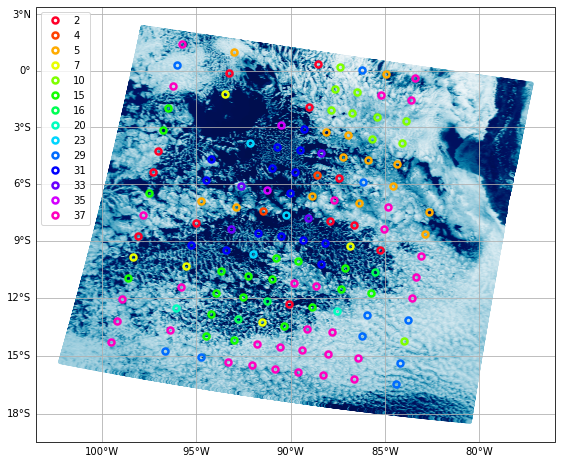

In [128]:
s2=80
ls=2.15
fmetaname = "MOD021KM.A2003015.1825"
mcmap="gist_rainbow" #"spring"

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Miller())
ax.scatter(lons, lats, c=swath[:,:,0], s=5, cmap=mycmap, rasterized=True)
label_uniques = np.unique(labels.data)
ls=2.5

seens = []
for  clon, clat, l in zip(lon_centers, lat_centers, labels.data):
    if not l in seens:
        sc = ax.plot(clon, clat, c='none',
                markeredgecolor=cmap_list[np.where( label_uniques == l)[0][0]], marker="o", 
                 markeredgewidth=ls, rasterized=True, label=l+1)
    else:
        sc = ax.plot(clon, clat, c='none',
                markeredgecolor=cmap_list[np.where( label_uniques == l)[0][0]], marker="o", 
                 markeredgewidth=ls, rasterized=True)
    seens.append(l)
#ax.legend()
handles, _labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
_labels, handles = zip(*sorted(zip(_labels, handles), key=lambda t: int(t[0]) ))
ax.legend(handles, _labels)


gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False


os.makedirs("./figs", exist_ok=True)
pdf = PdfPages(os.path.join("./figs", f'example_nc-{nclusters}_{fmetaname}.pdf'))
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None

### 10

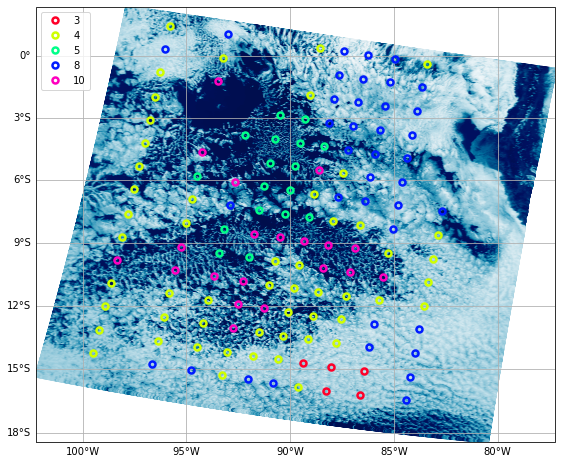

In [168]:
s2=80
ls=2.15
fmetaname = "MOD021KM.A2003015.1825"
mcmap="gist_rainbow" #"spring"

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Miller())
ax.set_extent((lons.min(), lons.max(), lats.min(), lats.max()), ccrs.Miller())
ax.scatter(lons, lats, c=swath[:,:,0], s=5, cmap=mycmap, rasterized=True)
label_uniques = np.unique(labels.data)
ls=2.5

seens = []
for  clon, clat, l in zip(lon_centers, lat_centers, labels.data):
    if not l in seens:
        sc = ax.plot(clon, clat, c='none',
                markeredgecolor=cmap_list[np.where( label_uniques == l)[0][0]], marker="o", 
                 markeredgewidth=ls, rasterized=True, label=l+1)
    else:
        sc = ax.plot(clon, clat, c='none',
                markeredgecolor=cmap_list[np.where( label_uniques == l)[0][0]], marker="o", 
                 markeredgewidth=ls, rasterized=True)
    seens.append(l)
#ax.legend()
handles, _labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
_labels, handles = zip(*sorted(zip(_labels, handles), key=lambda t: int(t[0]) ))
ax.legend(handles, _labels)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

os.makedirs("./figs", exist_ok=True)
pdf = PdfPages(os.path.join("./figs", f'example_nc-{nclusters}_{fmetaname}.pdf'))
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None

#### 20

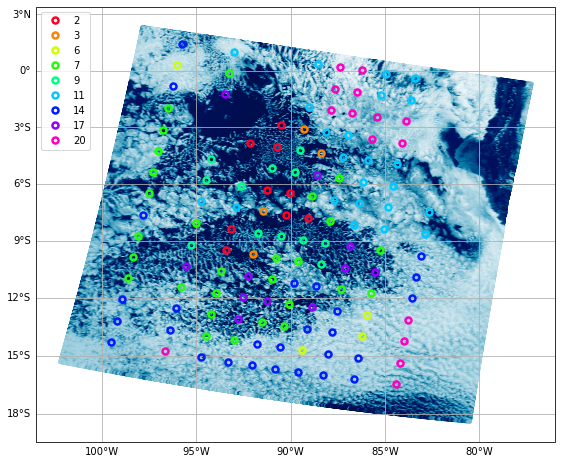

In [31]:
s2=80
ls=2.15
fmetaname = "MOD021KM.A2003015.1825"
mcmap="gist_rainbow" #"spring"

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Miller())
ax.scatter(lons, lats, c=swath[:,:,0], s=5, cmap=mycmap, rasterized=True)
label_uniques = np.unique(labels.data)
ls=2.5

seens = []
for  clon, clat, l in zip(lon_centers, lat_centers, labels.data):
    if not l in seens:
        sc = ax.plot(clon, clat, c='none',
                markeredgecolor=cmap_list[np.where( label_uniques == l)[0][0]], marker="o", 
                 markeredgewidth=ls, rasterized=True, label=l+1)
    else:
        sc = ax.plot(clon, clat, c='none',
                markeredgecolor=cmap_list[np.where( label_uniques == l)[0][0]], marker="o", 
                 markeredgewidth=ls, rasterized=True)
    seens.append(l)
#ax.legend()
handles, _labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
_labels, handles = zip(*sorted(zip(_labels, handles), key=lambda t: int(t[0]) ))
ax.legend(handles, _labels)


gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False


os.makedirs("./figs", exist_ok=True)
pdf = PdfPages(os.path.join("./figs", f'example_nc-{nclusters}_{fmetaname}.pdf'))
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None

#### 64

/home/tkurihana/.conda/envs/tf2-gpu/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:479: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return matplotlib.axes.Axes.draw(self, renderer=renderer, **kwargs)
/home/tkurihana/.conda/envs/tf2-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/tkurihana/.conda/envs/tf2-gpu/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


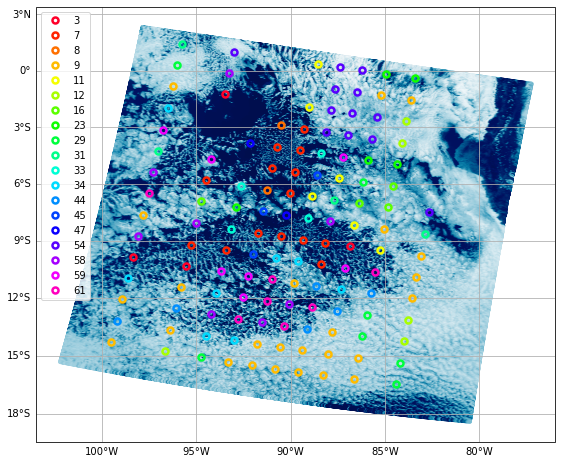

In [19]:
s2=80
ls=2.15
fmetaname = "MOD021KM.A2003015.1825"
mcmap="gist_rainbow" #"spring"

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Miller())
ax.scatter(lons, lats, c=swath[:,:,0], s=5, cmap=mycmap, rasterized=True)
label_uniques = np.unique(labels.data)
ls=2.5

seens = []
for  clon, clat, l in zip(lon_centers, lat_centers, labels.data):
    if not l in seens:
        sc = ax.plot(clon, clat, c='none',
                markeredgecolor=cmap_list[np.where( label_uniques == l)[0][0]], marker="o", 
                 markeredgewidth=ls, rasterized=True, label=l+1)
    else:
        sc = ax.plot(clon, clat, c='none',
                markeredgecolor=cmap_list[np.where( label_uniques == l)[0][0]], marker="o", 
                 markeredgewidth=ls, rasterized=True)
    seens.append(l)
#ax.legend()
handles, _labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
_labels, handles = zip(*sorted(zip(_labels, handles), key=lambda t: int(t[0]) ))
ax.legend(handles, _labels)


gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False


os.makedirs("./figs", exist_ok=True)
pdf = PdfPages(os.path.join("./figs", f'example_nc-{nclusters}_{fmetaname}.pdf'))
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None

#### 256

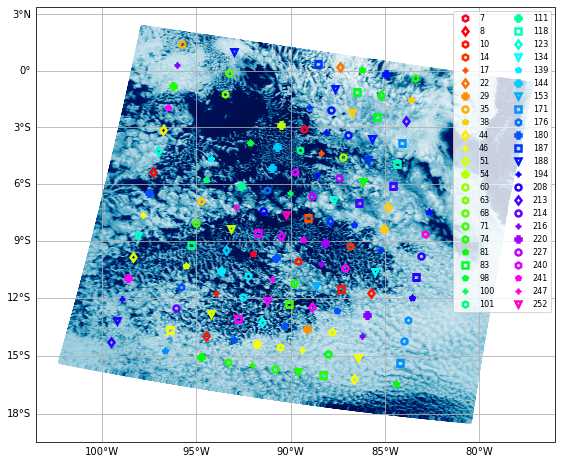

In [35]:
s2=80
ls=2.15
fmetaname = "MOD021KM.A2003015.1825"
mcmap="gist_rainbow" #"spring"

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Miller())
ax.scatter(lons, lats, c=swath[:,:,0], s=5, cmap=mycmap, rasterized=True)
label_uniques = np.unique(labels.data)
ls=2.5

seens = []
markers = ['o', 'v', 's', 'd', '*', 'P', 'h', '+']
for  idx, (clon, clat, l) in enumerate(zip(lon_centers, lat_centers, labels.data)):
    
    marker_index = idx % len(markers)
    marker = markers[marker_index]
    
    if not l in seens:
        sc = ax.plot(clon, clat, c='none',
                markeredgecolor=cmap_list[np.where( label_uniques == l)[0][0]], marker=marker, 
                 markeredgewidth=ls, rasterized=True, label=l+1)
    else:
        sc = ax.plot(clon, clat, c='none',
                markeredgecolor=cmap_list[np.where( label_uniques == l)[0][0]], marker=marker, 
                 markeredgewidth=ls, rasterized=True)
    seens.append(l)
#ax.legend()
handles, _labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
_labels, handles = zip(*sorted(zip(_labels, handles), key=lambda t: int(t[0]) ))
ax.legend(handles, _labels, ncol=2, loc='upper right', fontsize=8)


gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False


os.makedirs("./figs", exist_ok=True)
pdf = PdfPages(os.path.join("./figs", f'example_nc-{nclusters}_{fmetaname}.pdf'))
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None

-----------------
## Sorted version

In [13]:
# cluster range 1 -- N+1
df = pd.read_csv(f"./csvs/sort_cot-ctp_means-{nclusters}.csv", index_col=0)

In [14]:
def relabel_fn(df,labels,):
    labels_list = np.unique(labels.data).tolist() # get label range 0 - (N-1)
    rlabels = np.zeros( (len(labels.data)) ).astype(int)
    for ilabel in labels_list:
        idx = np.where(labels.data == ilabel) # get index
        rls = df[df['cluster']==ilabel+1]['rcluster'].values.item() # get relabeled number range 1 - N
        rlabels[idx] = int(rls)
    return rlabels

In [15]:
rlabels = relabel_fn(df,labels)

### 42

In [163]:
# automate
import matplotlib
mcmap='gist_ncar_r' #"nipy_spectral"
sc_cmap = cm.get_cmap(mcmap, np.unique(labels.data).size)    # PiYG

cmap_list = []
for i in range(sc_cmap.N):
    rgba = sc_cmap(i)
    # rgb2hex accepts rgb or rgba
    cname = matplotlib.colors.rgb2hex(rgba)
    #print(cname)
    if cname == '#000080':
        cmap_list.append('black')
    elif cname == '#003274':
        cmap_list.append('royalblue')
    elif cname == '#fef8fe':
        pass
        #cmap_list.append('blue')
    else:
        cmap_list.append(matplotlib.colors.rgb2hex(rgba))
np.random.shuffle(cmap_list)
cmap_list.append('blue')
print(cmap_list)

['#00adff', '#f09df2', '#00fdd2', '#fff400', '#ff4000', '#ffc40a', '#ff0090', '#00fe25', 'black', '#acff2f', '#a031fe', '#6cdb00', 'royalblue', 'blue']


In [259]:
cmap_list = ['#00adff', '#f09df2', '#00fdd2', '#fff400', '#ff4000', '#ffc40a', '#ff0090', '#00fe25', 'black', '#acff2f', '#a031fe', '#6cdb00', 'royalblue', 'blue']

/home/tkurihana/.conda/envs/tf2-gpu/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:479: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return matplotlib.axes.Axes.draw(self, renderer=renderer, **kwargs)
/home/tkurihana/.conda/envs/tf2-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/tkurihana/.conda/envs/tf2-gpu/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


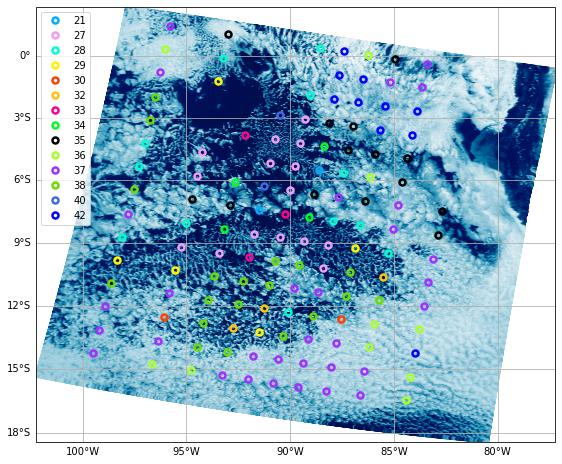

In [165]:
s2=80
ls=2.15
fmetaname = "MOD021KM.A2003015.1825"

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Miller())
#lc = ccrs.PlateCarree()
ax.set_extent((lons.min(), lons.max(), lats.min(), lats.max()), ccrs.Miller())
ax.scatter(lons, lats, c=swath[:,:,0], s=5, cmap=mycmap, rasterized=True)
label_uniques = np.unique(rlabels)
ls=2.5

seens = []
for  clon, clat, l in zip(lon_centers, lat_centers, rlabels):
    if not l in seens:
        sc = ax.plot(clon, clat, c='none',
                markeredgecolor=cmap_list[np.where( label_uniques == l)[0][0]], marker="o", 
                 markeredgewidth=ls, rasterized=True, label=l)
    else:
        sc = ax.plot(clon, clat, c='none',
                markeredgecolor=cmap_list[np.where( label_uniques == l)[0][0]], marker="o", 
                 markeredgewidth=ls, rasterized=True)
    seens.append(l)
#ax.legend()
handles, _labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
_labels, handles = zip(*sorted(zip(_labels, handles), key=lambda t: int(t[0]) ))
ax.legend(handles, _labels)


gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False


os.makedirs("./figs", exist_ok=True)
pdf = PdfPages(os.path.join("./figs", f'relabel-example_nc-{nclusters}_{fmetaname}.pdf'))
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None

## Swath + Histogram

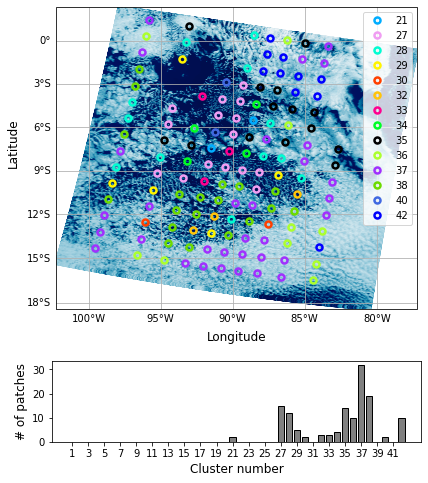

In [274]:
s2=80
ls=2.15
nstep=2
fs=12
fmetaname = "MOD021KM.A2003015.1825"
mcmap="gist_rainbow" #"spring"

fig = plt.figure(figsize=(10,8))
gs0 = gridspec.GridSpec(10, 12, figure=fig)
#gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])


################### Swath
ax = fig.add_subplot(gs0[:-3, :], projection=ccrs.Miller())
ax.set_extent((lons.min(), lons.max(), lats.min(), lats.max()), ccrs.Miller())
ax.scatter(lons, lats, c=swath[:,:,0], s=5, cmap=mycmap, rasterized=True)
label_uniques = np.unique(rlabels)
ls=2.5

seens = []
for  clon, clat, l in zip(lon_centers, lat_centers, rlabels):
    if not l in seens:
        sc = ax.plot(clon, clat, c='none',
                markeredgecolor=cmap_list[np.where( label_uniques == l)[0][0]], marker="o", 
                 markeredgewidth=ls, rasterized=True,transform= ccrs.Miller(), label=l)
    else:
        sc = ax.plot(clon, clat, c='none',
                markeredgecolor=cmap_list[np.where( label_uniques == l)[0][0]], marker="o", 
                 markeredgewidth=ls, rasterized=True, transform= ccrs.Miller())
    seens.append(l)
#ax.legend()
handles, _labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
_labels, handles = zip(*sorted(zip(_labels, handles), key=lambda t: int(t[0]) ))
ax.legend(handles, _labels, loc='upper right')

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

ax.text(-0.1, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',fontsize=fs,
        transform=ax.transAxes)
ax.text(0.5, -0.115, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',fontsize=fs,
        transform=ax.transAxes)

################# Histogram
ax2 = fig.add_subplot(gs0[-2:, 2:-2])
ax2.bar( np.arange(1,nclusters+1,1), [ len(np.where(rlabels == i)[0]) for i in np.arange(1,nclusters+1,1)  ] ,
         color='grey', edgecolor='black') # +1 for relabel case
ax2.set_xticks( np.arange(1,nclusters+1,nstep)  )
ax2.set_xlabel("Cluster number", fontsize=fs)
ax2.set_ylabel("# of patches", fontsize=fs)

os.makedirs("./figs", exist_ok=True)
pdf = PdfPages(os.path.join("./figs", f'hist_example_nc-{nclusters}_{fmetaname}.pdf'))
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None

### 10

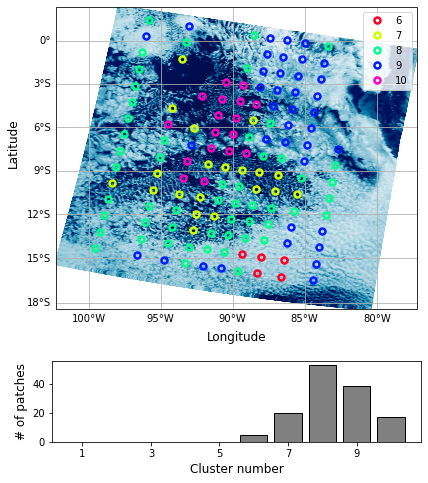

In [27]:
s2=80
ls=2.15
nstep=2
fs=12
fmetaname = "MOD021KM.A2003015.1825"
mcmap="gist_rainbow" #"spring"

fig = plt.figure(figsize=(10,8))
gs0 = gridspec.GridSpec(10, 12, figure=fig)
#gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])


################### Swath
ax = fig.add_subplot(gs0[:-3, :], projection=ccrs.Miller())
ax.set_extent((lons.min(), lons.max(), lats.min(), lats.max()), ccrs.Miller())
ax.scatter(lons, lats, c=swath[:,:,0], s=5, cmap=mycmap, rasterized=True)
label_uniques = np.unique(rlabels)
ls=2.5

seens = []
for  clon, clat, l in zip(lon_centers, lat_centers, rlabels):
    if not l in seens:
        sc = ax.plot(clon, clat, c='none',
                markeredgecolor=cmap_list[np.where( label_uniques == l)[0][0]], marker="o", 
                 markeredgewidth=ls, rasterized=True,transform= ccrs.Miller(), label=l)
    else:
        sc = ax.plot(clon, clat, c='none',
                markeredgecolor=cmap_list[np.where( label_uniques == l)[0][0]], marker="o", 
                 markeredgewidth=ls, rasterized=True, transform= ccrs.Miller())
    seens.append(l)
#ax.legend()
handles, _labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
_labels, handles = zip(*sorted(zip(_labels, handles), key=lambda t: int(t[0]) ))
ax.legend(handles, _labels, loc='upper right')

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

ax.text(-0.1, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',fontsize=fs,
        transform=ax.transAxes)
ax.text(0.5, -0.115, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',fontsize=fs,
        transform=ax.transAxes)

################# Histogram
ax2 = fig.add_subplot(gs0[-2:, 2:-2])
ax2.bar( np.arange(1,nclusters+1,1), [ len(np.where(rlabels == i)[0]) for i in np.arange(1,nclusters+1,1)  ] ,
         color='grey', edgecolor='black') # +1 for relabel case
ax2.set_xticks( np.arange(1,nclusters+1,nstep)  )
ax2.set_xlabel("Cluster number", fontsize=fs)
ax2.set_ylabel("# of patches", fontsize=fs)

os.makedirs("./figs", exist_ok=True)
pdf = PdfPages(os.path.join("./figs", f'hist_example_nc-{nclusters}_{fmetaname}.pdf'))
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None

##### without relabels

/home/tkurihana/.conda/envs/tf2-gpu/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:479: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return matplotlib.axes.Axes.draw(self, renderer=renderer, **kwargs)
/home/tkurihana/.conda/envs/tf2-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/tkurihana/.conda/envs/tf2-gpu/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


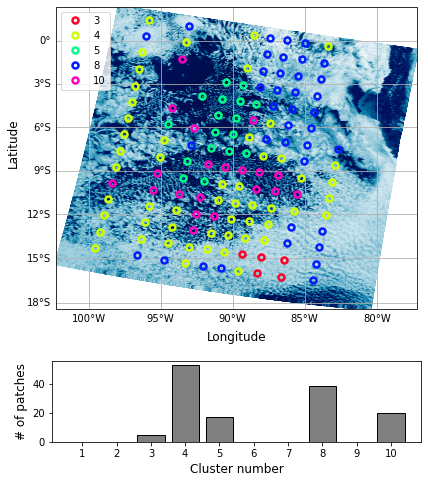

In [254]:
'''https://matplotlib.org/3.5.0/gallery/subplots_axes_and_figures/gridspec_nested.html#sphx-glr-gallery-subplots-axes-and-figures-gridspec-nested-py
'''
s2=80
ls=2.15
nstep=1
fs=12
fmetaname = "MOD021KM.A2003015.1825"
mcmap="gist_rainbow" #"spring"

fig = plt.figure(figsize=(10,8))
gs0 = gridspec.GridSpec(10, 12, figure=fig)
#gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])


################### Swath
ax = fig.add_subplot(gs0[:-3, :], projection=ccrs.Miller())
ax.set_extent((lons.min(), lons.max(), lats.min(), lats.max()), ccrs.Miller())
ax.scatter(lons, lats, c=swath[:,:,0], s=5, cmap=mycmap, rasterized=True)
label_uniques = np.unique(labels.data)
ls=2.5

seens = []
for  clon, clat, l in zip(lon_centers, lat_centers, labels.data):
    if not l in seens:
        sc = ax.plot(clon, clat, c='none',
                markeredgecolor=cmap_list[np.where( label_uniques == l)[0][0]], marker="o", 
                 markeredgewidth=ls, rasterized=True,transform= ccrs.Miller(), label=l+1)
    else:
        sc = ax.plot(clon, clat, c='none',
                markeredgecolor=cmap_list[np.where( label_uniques == l)[0][0]], marker="o", 
                 markeredgewidth=ls, rasterized=True, transform= ccrs.Miller())
    seens.append(l)
#ax.legend()
handles, _labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
_labels, handles = zip(*sorted(zip(_labels, handles), key=lambda t: int(t[0]) ))
ax.legend(handles, _labels)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

ax.text(-0.1, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',fontsize=fs,
        transform=ax.transAxes)
ax.text(0.5, -0.115, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',fontsize=fs,
        transform=ax.transAxes)

################# Histogram
ax2 = fig.add_subplot(gs0[-2:, 2:-2])
ax2.bar( np.arange(1,nclusters+1,1), [ len(np.where(labels.data == i)[0]) for i in np.arange(nclusters)  ] ,
         color='grey', edgecolor='black')
ax2.set_xticks( np.arange(1,nclusters+1,nstep)  )
ax2.set_xlabel("Cluster number", fontsize=fs)
ax2.set_ylabel("# of patches", fontsize=fs)

os.makedirs("./figs", exist_ok=True)
pdf = PdfPages(os.path.join("./figs", f'hist_example_nc-{nclusters}_{fmetaname}.pdf'))
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None